# Asphaltene deformation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Functions

In [2]:
def read_file(file_in):
  """
  Read file

  Parameters
  ----------
  file_in : string
    File (path and name) to be read

  Returns
  -------
  temp_data : list
    List of lists with the words in every line of the file read

  """

  temp_data = []

  f = open(file_in)

  for line in f:
    temp_data.append(line.split())

  f.close()

  return temp_data

In [3]:
def read_dump_file(file_in):
  """
  Read dump file from LAMMPS

  Parameters
  ----------
  file_in : string
    File (name and location) of dump file to be read

  Returns
  -------
  labels : list
    List of strings with labels
  box : numpy array
    Three dimensional numpy array (Ntimesteps x 3 x 2) with box dimensions (lo/hi)
  data_array : numpy array
    Three-dimensional numpy array (Ntimesteps x Nparticles x Nlabels). The Nlabels
    values are given in the line ITEM: ATOMS ...

  """
  
  data = read_file(file_in)
  
  numberOfParticles = int(data[3][0])
  offset = numberOfParticles + 9
  numberOfTimesteps = int(len(data)/offset)
  labels = data[8][2:]

  box = np.zeros((numberOfTimesteps, 3, 2))  
  data_array = np.zeros((numberOfTimesteps, numberOfParticles, len(labels)))
  m = 0
  for i in range(numberOfTimesteps):
    for k in range(3):
      box[i,k] = list(map(float, data[5+k+m*offset]))
    for j in range(numberOfParticles):
      data_array[i,j] = list(map(float, data[9+j+m*offset]))
    m += 1
  
  return(labels, box, data_array)

In [4]:
def distance(r1, r2, L):
  """
  Caclulate minimum distance in periodic boxes

  Parameters
  ----------
  r1 : array
    Vector with coordinates of particle 1
  r2 : array
    Vector with coordinates of particle 2
  L : array
    Vector with box dimensions

  Returns
  -------
  d : scalar
    Minimum distance between particles 1 and 2

  """

  dr = abs(r1-r2)
  dR = L - dr

  minr=[]
  for i in range(3):
    if dr[i] < dR[i]:
      minr.append(dr[i])
    else:
      minr.append(dR[i])

  return(np.linalg.norm(minr))

In [5]:
def unwrap(rf, rt, L):
  """
  Unwrap coordinates of test particle (rt) in periodic boxes

  Parameters
  ----------
  rf : array
    Vector with coordinates of fixed particle
  rt : array
    Vector with coordinates of test particle
  L : array
    Vector with box dimensions

  Returns
  -------
  ru : array
    Vector with unwrapped coordinates of test particle

  """

  dr = rt - rf
  dR = L - abs(dr)

  unwr=[]
  for i in range(3):
    if abs(dr[i]) < dR[i]:
      unwr.append(rt[i])
    else:
      if dr[i] < 0:
        unwr.append(rt[i] + L[i])
      else:
        unwr.append(rt[i] - L[i])

  return(np.array(unwr))

In [6]:
def angle_between(v1, v2):
  """
  Returns the angle in degrees between vectors v1 and v2
    
  Parameters
  ----------
  v1 : array
    Vector
  v2 : array
    Vector
  
  Returns
  -------
  q : scalar
    Angle (in degrees) between vectors v1 and v2
    
  """
  
  v1_norm = np.linalg.norm(v1)
  v2_norm = np.linalg.norm(v2)
  
  return np.arccos(np.dot(v1, v2)/(v1_norm*v2_norm))*180./np.pi

## Definitions

Colors from Mathematica:

In [7]:
colors = [(0.368417,0.506779,0.709798),\
          (0.880722,0.611041,0.142051),\
          (0.560181,0.691569,0.194885),\
          (0.922526,0.385626,0.209179),\
          (0.528488,0.470624,0.701351),\
          (0.772079,0.431554,0.102387),\
          (0.363898,0.618501,0.782349),\
          (1.,0.75,0.),\
          (0.647624,0.37816,0.614037),\
          (0.571589,0.586483,0.),\
          (0.915,0.3325,0.2125),\
          (0.400822,0.522007,0.85),\
          (0.972829,0.621644,0.073362),\
          (0.736783,0.358,0.503027),\
          (0.280264,0.715,0.429209)]

Font size:

In [8]:
ft = 19

LaTeX font:

In [9]:
# ft = 22
# plt.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif" : "Helvetica",
#     "mathtext.default": "regular"})

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "Charter"
# })

## Reference values for bonds and angles

In [10]:
reference_bond = {1 : 3.37698,\
                  2 : 3.82959,\
                  3 : 4.2822 ,\
                  4 : 3.86299,\
                  5 : 4.3135 ,\
                  6 : 4.278  ,\
                  7 : 3.56449}

In [11]:
reference_angle = {1 : 180     ,\
                   2 : 120     ,\
                   3 : 176.162 ,\
                   4 : 172.323 ,\
                   5 : 116.162 ,\
                   6 :  63.8383,\
                   7 : 150     ,\
                   8 : 157.6   ,\
                   9 : 90}

Bonds formed in molecule 1 (they repeat for all other molecules)

In [12]:
## Format : [bond type, bead 1, bead 2]

bonds = np.array(
        [[1, 1, 10],\
         [1, 1, 6],\
         [1, 1, 2],\
         [1, 2, 10],\
         [1, 2, 6],\
         [1, 2, 7],\
         [1, 2, 3],\
         [1, 3, 8],\
         [1, 3, 7],\
         [1, 3, 4],\
         [1, 6, 12],\
         [1, 6, 7],\
         [1, 7, 8],\
         [1, 7, 12],\
         [7, 12, 20],\
         [1, 4, 11],\
         [1, 4, 9],\
         [1, 4, 5],\
         [1, 4, 8],\
         [1, 5, 11],\
         [1, 5, 9],\
         [4, 5, 15],\
         [1, 8, 9],\
         [2, 8, 14],\
         [1, 9, 13],\
         [2, 9, 14],\
         [4, 11, 19],\
         [3, 13, 14],\
         [5, 15, 16],\
         [6, 16, 17],\
         [5, 17, 18]])

Angles formed in molecule 1 (they repeat for all other molecules)

In [13]:
## Format : [angle type, bead 1, bead 2, bead 3]

angles = np.array(
          [[1, 1, 2, 3],\
          [1, 7, 2, 10],\
          [2, 3, 2, 10],\
          [1, 2, 3, 4],\
          [1, 1, 6, 12],\
          [1, 6, 7, 8],\
          [1, 3, 7, 12],\
          [7, 7, 12, 20],\
          [9, 6, 12, 20],\
          [1, 3, 4, 5],\
          [1, 8, 4, 11],\
          [2, 3, 4, 11],\
          [7, 9, 5, 15],\
          [9, 11, 5, 15],\
          [1, 7, 8, 9],\
          [3, 3, 8, 14],\
          [5, 7, 8, 14],\
          [4, 4, 9, 13],\
          [3, 5, 9, 14],\
          [6, 13, 9, 14],\
          [7, 4, 11, 19],\
          [9, 5, 11, 19],\
          [8, 5, 15, 16],\
          [8, 15, 16, 17],\
          [8, 16, 17, 18]])

## Get data and calculate stretching and bending

In [14]:
pressure = [50, 75, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 300, 400, 700]

In [15]:
Npress = len(pressure)

In [16]:
for ip in range(Npress):
  file_in = '../data/' + str(pressure[ip]) + '_atm/5-production_npt/clusters.dat'
  labels, box, data = read_dump_file(file_in)
  Ntimesteps, Nparticles, Nlabels = data.shape
  
  # Atom id index
  iid = labels.index('id')
  
  # Molecule index
  imol = labels.index('mol')
  
  # Atom type index
  iatype = labels.index('type')

  # Coordinates index
  ix = labels.index('x')
  iy = labels.index('y')
  iz = labels.index('z')

  for it in range(Ntimesteps):
    # Gather particles by molecule id
    molecules = {}
    for line in data[it]:
      molid = int(line[imol])
      if molid not in list(molecules.keys()):
        molecules[molid] = [line]
      else:
        molecules[molid].append(line)

    # Number of molecules
    Nmolecules = len(molecules)
    
    if ip == 0 and it == 0:
      # Number of beads per molecule
      npm = int(Nparticles/Nmolecules)
      # Initialize variables to store deformations
      stretch_vec = np.zeros((Npress, Ntimesteps, Nmolecules, len(bonds)))
      bend_vec = np.zeros((Npress, Ntimesteps, Nmolecules, len(angles)))
      
    # Box dimensions at current timestep
    L = box[it][:,1] - box[it][:,0]

    for i in molecules.keys():
      # Find the indices that would sort the beads in molecule by id
      idx = []
      for line in molecules[i]:
        idx.append(line[iid])
      index = np.argsort(idx)
      
      # Bond deformation
      stretch = []
      for t, b1, b2 in bonds:
        p1 = molecules[i][index[b1-1]][[ix, iy, iz]]
        p2 = molecules[i][index[b2-1]][[ix, iy, iz]]
        d12 = distance(p1, p2, L)
        stretch.append(d12 - reference_bond[t])
      stretch_vec[ip, it, i-1, :] = stretch
    
      # Angle deformation
      bend = []
      for t, b1, b2, b3 in angles:
        pvertex = molecules[i][index[b2-1]][[ix, iy, iz]]
        p1 = unwrap(pvertex, molecules[i][index[b1-1]][[ix, iy, iz]], L)
        p3 = unwrap(pvertex, molecules[i][index[b3-1]][[ix, iy, iz]], L)
        q123 = angle_between(p1 - pvertex, p2 - pvertex)
        bend.append(q123 - reference_angle[t])
      bend_vec[ip, it, i-1, :] = bend
      
  print('Done pressure {:d} atm'.format(pressure[ip]))

Done pressure 50 atm
Done pressure 75 atm
Done pressure 100 atm
Done pressure 110 atm
Done pressure 120 atm
Done pressure 130 atm
Done pressure 140 atm
Done pressure 150 atm
Done pressure 160 atm
Done pressure 170 atm
Done pressure 180 atm
Done pressure 190 atm
Done pressure 200 atm
Done pressure 210 atm
Done pressure 220 atm
Done pressure 300 atm
Done pressure 400 atm
Done pressure 700 atm


## Time averages

Dimensions:

stretch_avg : (Npress, Nmolecules, Nbonds)\
bend_avg    : (Npress, Nmolecules, Nangles)

In [17]:
stretch_avg = np.mean(stretch_vec, axis=1)

In [18]:
bend_avg = np.mean(bend_vec, axis=1)

## Histograms

Deformation distributions

Dimensions:

stretch_hst : (Npress, 1)\
bend_hst    : (Npress, 1)

Axis 1 corresponds to 2D tuples

In [19]:
smin = np.amin(stretch_avg)
smax = np.amax(stretch_avg)
bins = np.linspace(smin - 0.002, smax + 0.002, num=11, endpoint=True, retstep=False, dtype=None, axis=0)

stretch_hst = []
for i in range(Npress):
  hst = np.histogram(stretch_avg[i], bins=bins)
  stretch_hst.append(hst)

In [20]:
aux = []
for i in range(Npress):
  aux.append(stretch_hst[i][0])
stmax = np.amax(aux)
print(stmax)

507


In [21]:
bmin = np.amin(bend_avg)
bmax = np.amax(bend_avg)
bins = np.linspace(bmin - 2, bmax + 2, num=11, endpoint=True, retstep=False, dtype=None, axis=0)

bend_hst = []
for i in range(Npress):
  hst = np.histogram(bend_avg[i], bins=bins)
  bend_hst.append(hst)

In [22]:
aux = []
for i in range(Npress):
  aux.append(bend_hst[i][0])
bnmax = np.amax(aux)
print(bnmax)

282


### Plots

Bond stretching:

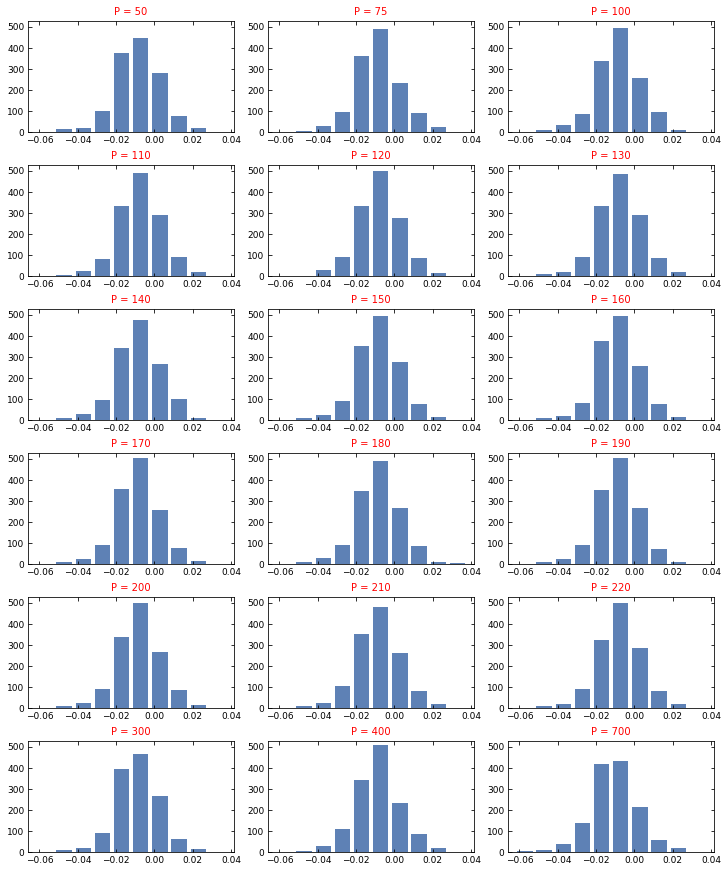

In [23]:
fig = plt.figure(constrained_layout=True, figsize=(10, 12))
axs = fig.subplots(6, 3)
lft = 10
for nn, ax in enumerate(axs.flatten()):
  ax.set_prop_cycle(color=colors)
  ax.set_ylim([0, stmax+20])
  ax.set_title('P = {:d}'.format(pressure[nn]), fontsize=lft, color='r')
  ax.bar(stretch_hst[nn][1][:-1], stretch_hst[nn][0], align='center', width=0.008)
  ax.tick_params(which='both', labelsize=0.9*lft, direction="in", right=True, top=True)
plt.show()

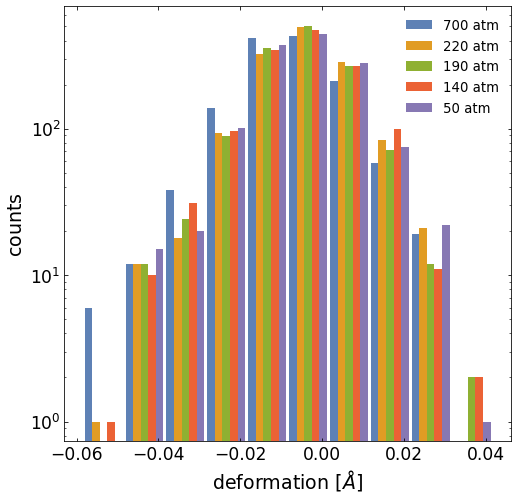

In [24]:
press_selection = [700, 220, 190, 140, 50]
wdt = (stretch_hst[0][1][-1] - stretch_hst[0][1][-2])/(len(press_selection)+0.4)
plt.figure(figsize=(8,8))
plt.gca().set_prop_cycle(color=colors)
i = 0
for p in press_selection:
  plt.bar(stretch_hst[pressure.index(p)][1][:-1]+wdt*i, stretch_hst[pressure.index(p)][0], align='center', width=wdt, label='{:d} atm'.format(p))
  i += 1
plt.tick_params(which='both', labelsize=0.9*ft, direction="in", right=True, top=True)
plt.xlabel(r'$\mathrm{deformation} \ [\AA]$', fontsize=ft)
plt.ylabel(r'$\mathrm{counts}$', fontsize=ft)
plt.yscale('log')
plt.legend(loc='upper right', fontsize=0.7*ft, frameon=False)
plt.show()

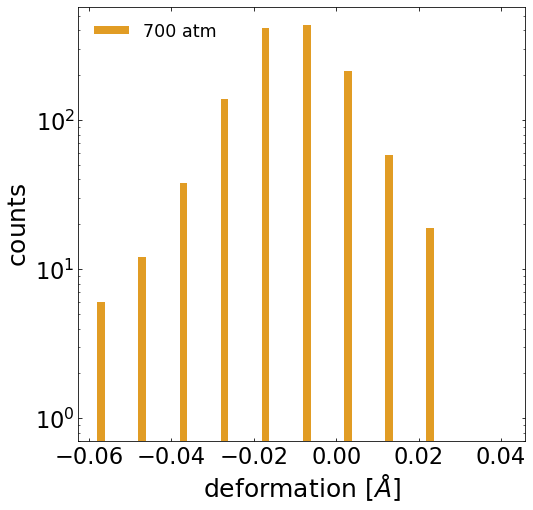

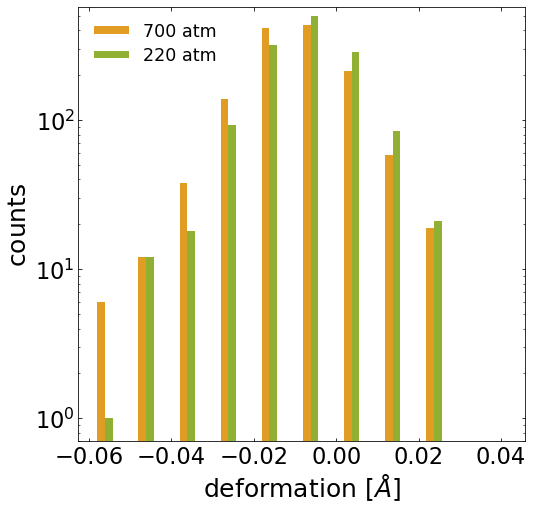

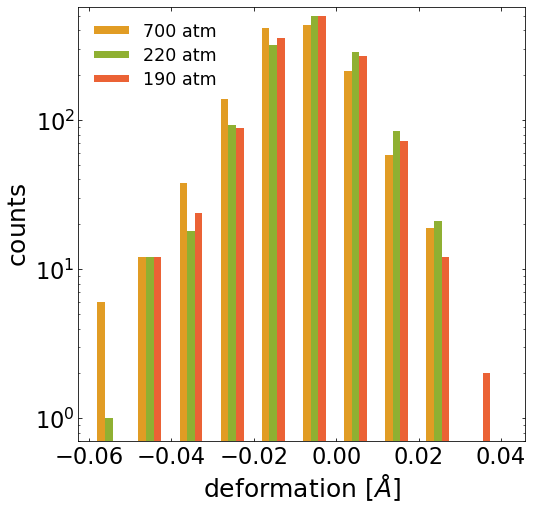

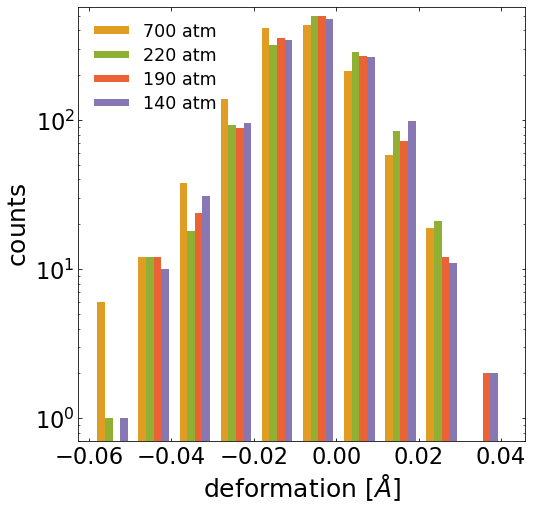

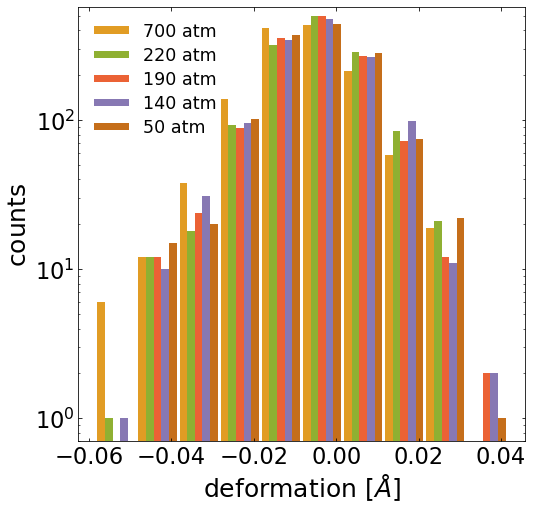

In [25]:
press_selection = [700, 220, 190, 140, 50]
wdt = (stretch_hst[0][1][-1] - stretch_hst[0][1][-2])/(len(press_selection)+0.4)
lft = 25
for j in range(len(press_selection)):
  plt.figure(figsize=(8,8))
  i = 0
  for p in press_selection[:j+1]:
    plt.bar(stretch_hst[pressure.index(p)][1][:-1]+wdt*i, stretch_hst[pressure.index(p)][0],\
            color=colors[i+1], align='center', width=wdt, label='{:d} atm'.format(p))
    i += 1
  plt.tick_params(which='both', labelsize=0.9*lft, direction="in", right=True, top=True)
  plt.xlabel(r'$\mathrm{deformation} \ [\AA]$', fontsize=lft)
  plt.ylabel(r'$\mathrm{counts}$', fontsize=lft)
  plt.yscale('log')
  plt.ylim([0.7, stmax + 70])
  plt.xlim([smin - 0.0075, smax + 0.005])
  plt.legend(loc='upper left', fontsize=0.7*lft, frameon=False, handleheight=0.25, labelspacing=0.35)  
#   plt.savefig('../plots/stretch_{:d}.png'.format(j+1), dpi=300, transparent=False, bbox_inches='tight')
  plt.show()

Angle bending:

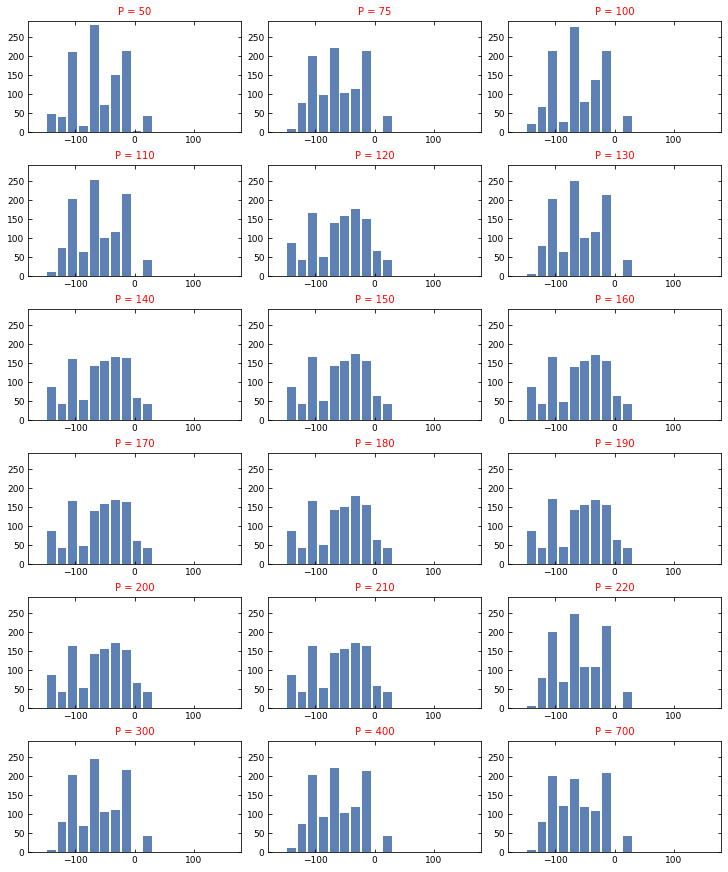

In [26]:
fig = plt.figure(constrained_layout=True, figsize=(10, 12))
axs = fig.subplots(6, 3)
lft = 10
for nn, ax in enumerate(axs.flatten()):
  ax.set_prop_cycle(color=colors)
  ax.set_ylim([0, bnmax+10])
  ax.set_xlim([-180, 180])
  ax.set_title('P = {:d}'.format(pressure[nn]), fontsize=lft, color='r')
  ax.bar(bend_hst[nn][1][:-1], bend_hst[nn][0], align='center', width=15)
  ax.tick_params(which='both', labelsize=0.9*lft, direction="in", right=True, top=True)
plt.show()

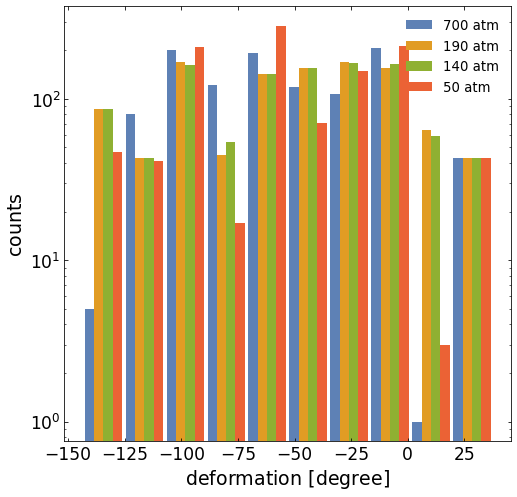

In [31]:
press_selection = [700, 190, 140, 50]
wdt = (bend_hst[0][1][-1] - bend_hst[0][1][-2])/(len(press_selection)+0.4)
plt.figure(figsize=(8,8))
plt.gca().set_prop_cycle(color=colors)
i = 0
for p in press_selection:
  plt.bar(bend_hst[pressure.index(p)][1][:-1]+wdt*i, bend_hst[pressure.index(p)][0], align='center', width=wdt, label='{:d} atm'.format(p))
  i += 1
plt.tick_params(which='both', labelsize=0.9*ft, direction="in", right=True, top=True)
plt.xlabel(r'$\mathrm{deformation \ [degree]}$', fontsize=ft)
plt.ylabel(r'$\mathrm{counts}$', fontsize=ft)
plt.yscale('log')
plt.legend(loc='upper right', fontsize=0.7*ft, frameon=False)
plt.show()

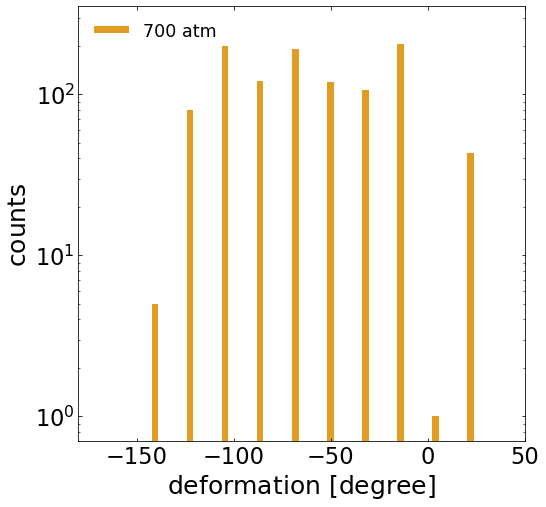

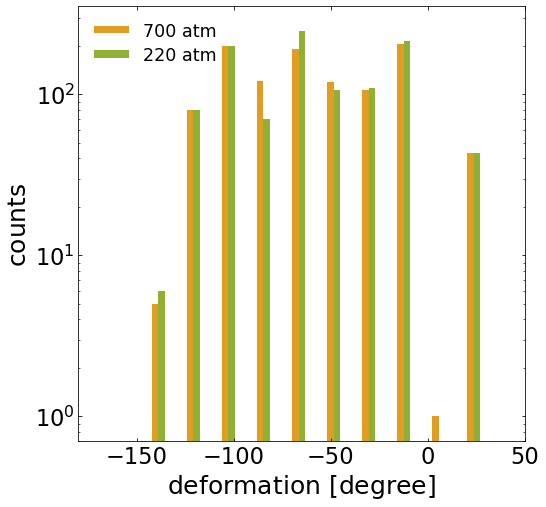

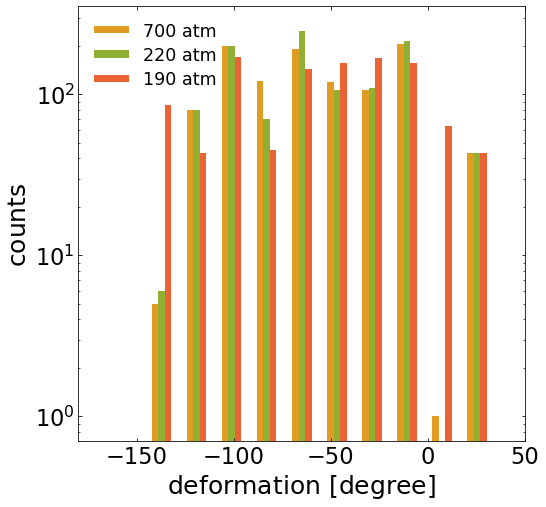

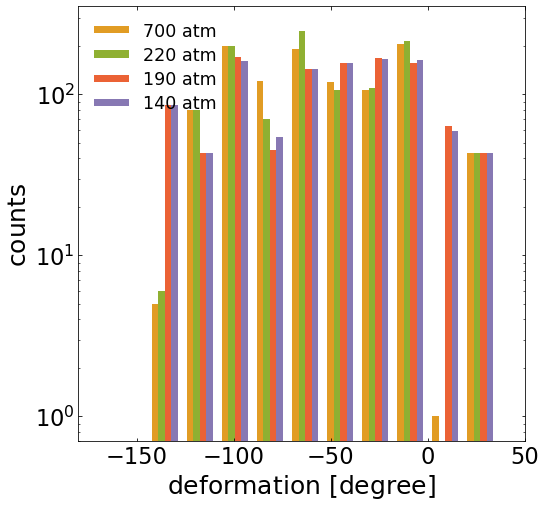

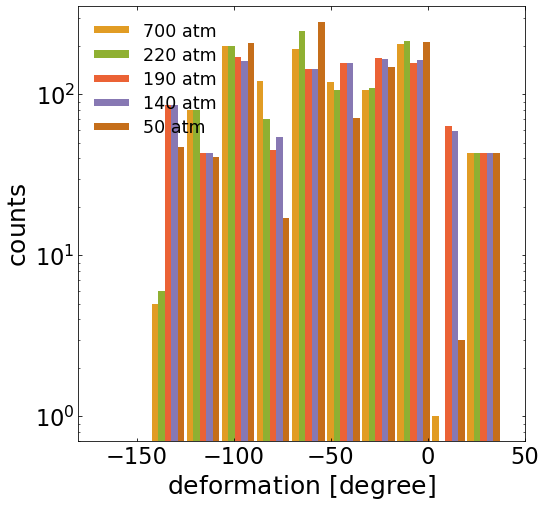

In [32]:
press_selection = [700, 220, 190, 140, 50]
wdt = (bend_hst[0][1][-1] - bend_hst[0][1][-2])/(len(press_selection)+0.4)
lft = 25
for j in range(len(press_selection)):
  plt.figure(figsize=(8,8))
  i = 0
  for p in press_selection[:j+1]:
    plt.bar(bend_hst[pressure.index(p)][1][:-1]+wdt*i, bend_hst[pressure.index(p)][0],\
            color=colors[i+1], align='center', width=wdt, label='{:d} atm'.format(p))
    i += 1
  plt.tick_params(which='both', labelsize=0.9*lft, direction="in", right=True, top=True)
  plt.xlabel(r'$\mathrm{deformation \ [degree]}$', fontsize=lft)
  plt.ylabel(r'$\mathrm{counts}$', fontsize=lft)
  plt.yscale('log')
  plt.ylim([0.7, bnmax + 70])
  plt.xlim([-180, 50])
  plt.legend(loc='upper left', fontsize=0.7*lft, frameon=False, handleheight=0.25, labelspacing=0.35)  
#   plt.savefig('../plots/bend_{:d}.png'.format(j+1), dpi=300, transparent=False, bbox_inches='tight')
  plt.show()